In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d jtiptj/chest-xray-pneumoniacovid19tuberculosis

 99% 1.73G/1.74G [00:14<00:00, 206MB/s]
100% 1.74G/1.74G [00:14<00:00, 130MB/s]


In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, optimizers, losses, metrics, regularizers

In [8]:
import zipfile
import os

# Replace 'your_dataset_directory.zip' with the actual zip file name
zip_file_path = '/content/chest-xray-pneumoniacovid19tuberculosis.zip'
extracted_folder_path = '/content/dataset/'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

In [9]:
your_dataset_directory = '/content/dataset'

# Use ImageDataGenerator to augment and normalize the data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Use flow_from_directory to load the data directly from folders
train_generator = train_datagen.flow_from_directory(
    directory=your_dataset_directory + '/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Change class_mode to 'categorical'
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=your_dataset_directory + '/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=your_dataset_directory + '/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 6326 images belonging to 4 classes.
Found 38 images belonging to 4 classes.
Found 771 images belonging to 4 classes.


In [10]:
# Load the ResNet50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 2s 0us/step


In [11]:
num_classes = len(train_generator.class_indices)
batch_size = 32
epochs = 20
learning_rate = 0.000001

In [12]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [13]:
# Add custom layers on top of the base ResNet50 model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)  # Add a dense layer with 512 neurons
x = Dense(256, activation='relu')(x)  # Add another dense layer with 256 neurons
predictions = Dense(num_classes, activation='softmax')(x)  # Adjust num_classes to the number of classes in your dataset

model = Model(inputs=base_model.input, outputs=predictions)

for layer in model.layers[:100]:
    layer.trainable = True

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary to review the architecture
model.summary()

# Set up callbacks (optional but recommended)
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [14]:
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

Epoch 1/20
198/198 [==============================] - ETA: 0s - loss: 1.0236 - accuracy: 0.5664

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


198/198 [==============================] - 200s 791ms/step - loss: 1.0236 - accuracy: 0.5664 - val_loss: 2.1604 - val_accuracy: 0.3158
Epoch 2/20
198/198 [==============================] - 150s 757ms/step - loss: 0.6590 - accuracy: 0.7931 - val_loss: 2.6813 - val_accuracy: 0.3158
Epoch 3/20
198/198 [==============================] - 159s 801ms/step - loss: 0.4906 - accuracy: 0.8408 - val_loss: 2.0976 - val_accuracy: 0.3158
Epoch 4/20
198/198 [==============================] - 154s 775ms/step - loss: 0.4008 - accuracy: 0.8669 - val_loss: 1.3505 - val_accuracy: 0.4211
Epoch 5/20
198/198 [==============================] - 161s 814ms/step - loss: 0.3248 - accuracy: 0.8987 - val_loss: 1.2024 - val_accuracy: 0.5789
Epoch 6/20
198/198 [==============================] - 157s 793ms/step - loss: 0.2810 - accuracy: 0.9167 - val_loss: 1.0547 - val_accuracy: 0.6316
Epoch 7/20
198/198 [==============================] - 155s 780ms/step - loss: 0.2371 - accuracy: 0.9311 - val_loss: 0.8260 - val_accura

In [15]:
# Save the trained model as an h5 file
model.save('/content/fine_tuned_resnet50.h5')

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

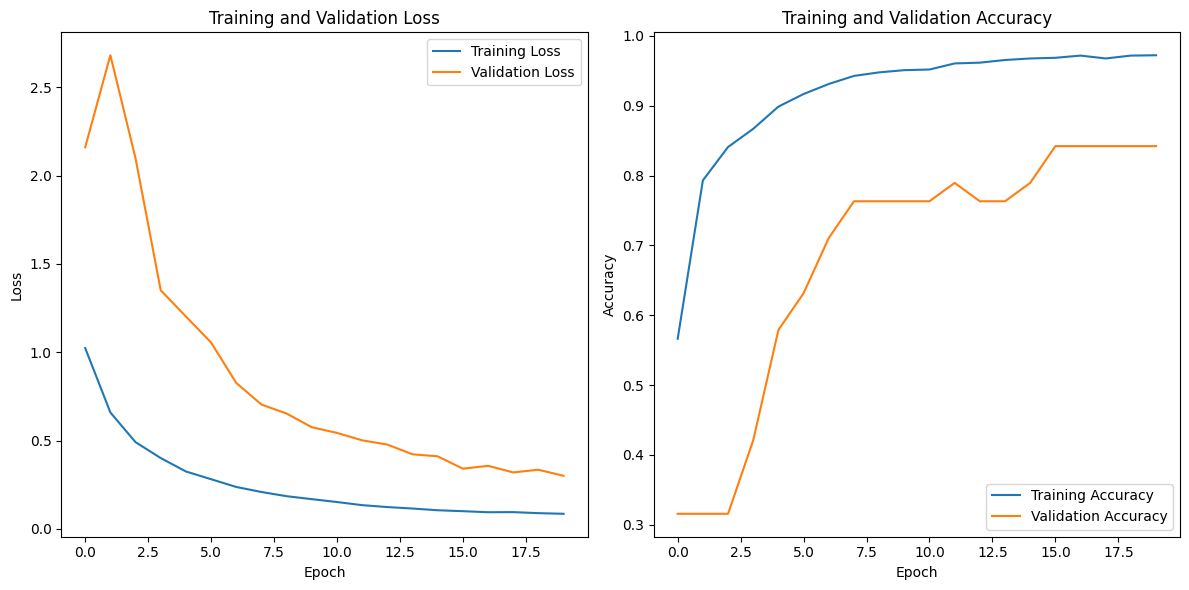

In [17]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [18]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=32)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy * 100)

25/25 [==============================] - 9s 330ms/step - loss: 0.2222 - accuracy: 0.9209
Test Loss: 0.22223685681819916
Test Accuracy: 92.0881986618042


25/25 [==============================] - 9s 283ms/step


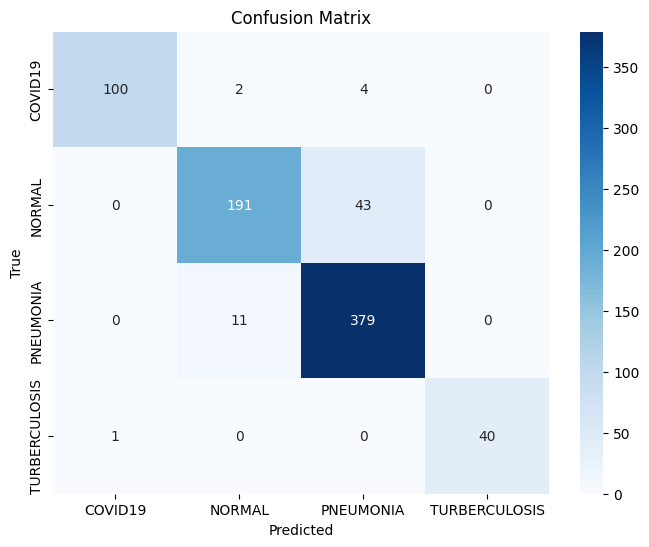


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       106
           1       0.94      0.82      0.87       234
           2       0.89      0.97      0.93       390
           3       1.00      0.98      0.99        41

    accuracy                           0.92       771
   macro avg       0.95      0.93      0.94       771
weighted avg       0.92      0.92      0.92       771



In [19]:
# Generate predictions on the test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to one-hot encoding
y_true_onehot = test_generator.classes

# Create confusion matrix
conf_matrix = confusion_matrix(y_true_onehot, y_pred_classes)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true_onehot, y_pred_classes))

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
